/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_5967/655060009.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_economie = pd.read_sql(query_economie, conn)
/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_5967/655060009.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_election = pd.read_sql(query_election, conn)


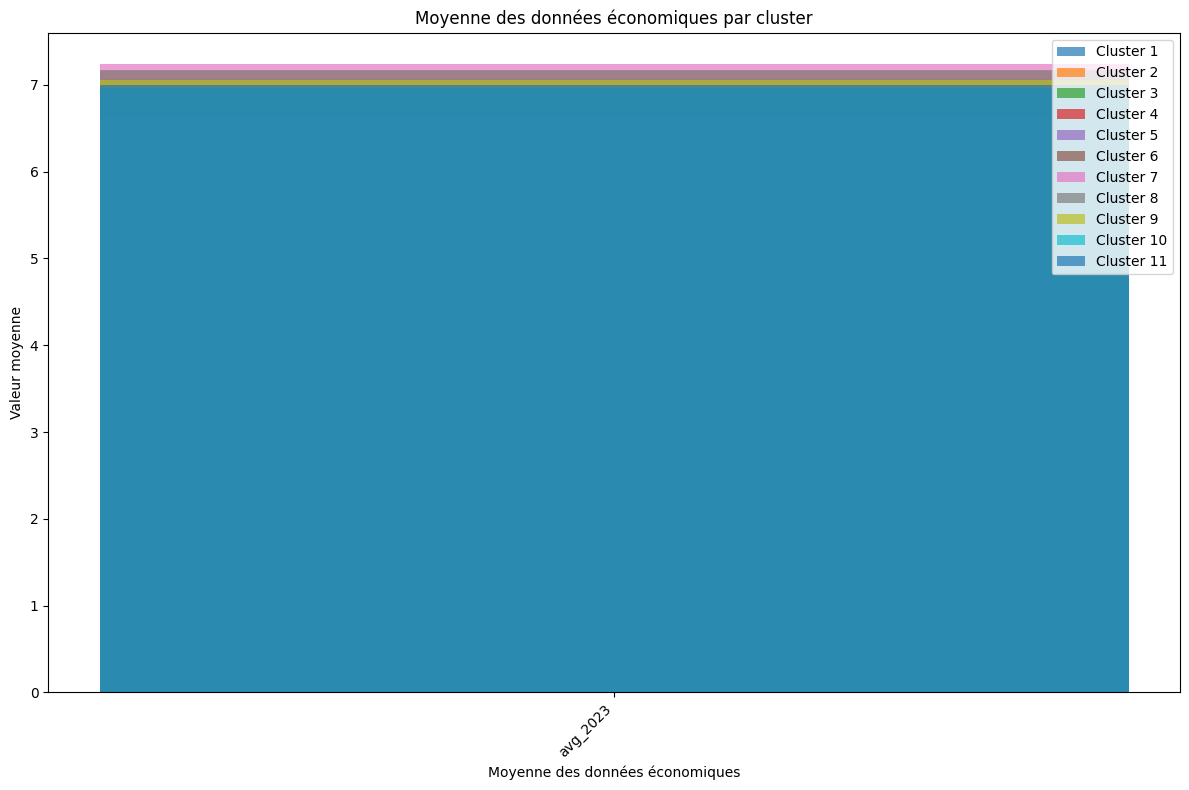

In [39]:
from sklearn.impute import SimpleImputer
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# Dictionnaire de correspondance entre les noms des partis politiques et leurs identifiants numériques
id_to_party_dict = {
    1: "Lutte Ouvrière",
    2: "Parti Communiste Français",
    3: "La République En Marche",
    4: "Résistons",
    5: "Rassemblement National",
    6: "Reconquête",
    7: "La France Insoumise",
    8: "Parti Socialiste",
    9: "Europe Écologie Les Verts",
    10: "Les Républicains",
    11: "Nouveau Parti Anticapitaliste",
    12: "Debout La France"
}

# Paramètres de connexion à la base de données PostgreSQL
conn_params = {
    "host": "localhost",
    "port": "15432",
    "database": "postgres",
    "user": "admin",
    "password": "admin"
}

# Connexion à la base de données
conn = psycopg2.connect(**conn_params)

# Requête SQL pour récupérer les données de la table economie
query_economie = """
    SELECT avg_1982, avg_1983, avg_1984, avg_1985, avg_1986, avg_1987, avg_1988, avg_1989, avg_1990,
           avg_1991, avg_1992, avg_1993, avg_1994, avg_1995, avg_1996, avg_1997, avg_1998, avg_1999,
           avg_2000, avg_2001, avg_2002, avg_2003, avg_2004, avg_2005, avg_2006, avg_2007, avg_2008,
           avg_2009, avg_2010, avg_2011, avg_2012, avg_2013, avg_2014, avg_2015, avg_2016, avg_2017,
           avg_2018, avg_2019, avg_2020, avg_2021, avg_2022, avg_2023, code_postal
    FROM economie
"""
df_economie = pd.read_sql(query_economie, conn)

# Requête SQL pour récupérer les données de la table electiont1
query_election = """
    SELECT "Parti 1", "% Voix/Exp 1", "Parti 2", "% Voix/Exp 2", "Parti 3", "% Voix/Exp 3", 
           "Parti 4", "% Voix/Exp 4", "Parti 5", "% Voix/Exp 5", "Parti 6", "% Voix/Exp 6", 
           "Parti 7", "% Voix/Exp 7", "Parti 8", "% Voix/Exp 8", "Parti 9", "% Voix/Exp 9", 
           "Parti 10", "% Voix/Exp 10", "Parti 11", "% Voix/Exp 11", "Parti 12", "% Voix/Exp 12"
    FROM election_2022_t1
"""
df_election = pd.read_sql(query_election, conn)
# Fermeture de la connexion
conn.close()

# Mapper les noms des partis politiques aux identifiants numériques
party_to_id_dict = {v: k for k, v in id_to_party_dict.items()}

# Convertir les noms des partis politiques en identifiants numériques dans le DataFrame df_election
for i in range(1, 13):
    df_election[f"Parti {i}"] = df_election[f"Parti {i}"].map(party_to_id_dict)

# Fusionner les données économiques avec les données de l'élection
df_combined = pd.concat([df_election, df_economie], axis=1)

# Sélection des colonnes à utiliser pour le clustering
X_train = df_combined.drop(columns=["Parti 1", "Parti 2", "Parti 3", "Parti 4", "Parti 5",
                                    "Parti 6", "Parti 7", "Parti 8", "Parti 9", "Parti 10",
                                    "Parti 11", "Parti 12"])

# Remplacer les valeurs NaN par la moyenne de chaque colonne
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Entraînement du modèle de clustering K-means avec 11 clusters sur les données imputées
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(X_train_imputed)

# Ajout des clusters prédits au DataFrame combiné
df_combined["cluster"] = kmeans.labels_

plt.figure(figsize=(12, 8))
for cluster in range(11):
    cluster_data = df_combined[df_combined["cluster"] == cluster]
    economic_values = cluster_data.drop(columns=["cluster", "code_postal", 
                                                  "Parti 1", "Parti 2", "Parti 3", "Parti 4", "Parti 5",
                                                  "Parti 6", "Parti 7", "Parti 8", "Parti 9", "Parti 10",
                                                  "Parti 11", "Parti 12",
                                                  "% Voix/Exp 1", "% Voix/Exp 2", "% Voix/Exp 3", 
                                                  "% Voix/Exp 4", "% Voix/Exp 5", "% Voix/Exp 6", 
                                                  "% Voix/Exp 7", "% Voix/Exp 8", "% Voix/Exp 9", 
                                                  "% Voix/Exp 10", "% Voix/Exp 11", "% Voix/Exp 12",
                                                  "avg_1982", "avg_1983", "avg_1984", "avg_1985",
                                                  "avg_1986", "avg_1987", "avg_1988", "avg_1989",
                                                  "avg_1990", "avg_1991", "avg_1992", "avg_1993",
                                                  "avg_1994", "avg_1995", "avg_1996", "avg_1997",
                                                  "avg_1998", "avg_1999", "avg_2000", "avg_2001",
                                                  "avg_2002", "avg_2003", "avg_2004", "avg_2005",
                                                  "avg_2006", "avg_2007", "avg_2008", "avg_2009",
                                                  "avg_2010", "avg_2011", "avg_2012", "avg_2013",
                                                  "avg_2014", "avg_2015", "avg_2016", "avg_2017",
                                                  "avg_2018", "avg_2019", "avg_2020", "avg_2021",
                                                  "avg_2022"])  
    economic_mean = economic_values.mean()
    plt.bar(economic_mean.index, economic_mean.values, label=f"Cluster {cluster + 1}", alpha=0.7)

plt.xlabel("Moyenne des données économiques")
plt.ylabel("Valeur moyenne")
plt.title("Moyenne des données économiques par cluster")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




